# COVID-19 관련 통계 정보 수집, 저장, 분석 및 시각화

### 웹 크롤링

In [1]:
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import datetime

driver = webdriver.Chrome("C:/miniProject/chromedriver.exe") # chromedriver 설치 경로
url = "https://www.naver.com/"
driver.get(url)
time.sleep(3)

def naver_searching(word):
    url = "https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=" + word
    return url

word = "코로나 현황"
url = naver_searching(word)
driver.get(url)
time.sleep(3)

def get_current_week_content(driver): # 최근 7일간 국내 발생 및 해외 유입 신규 확진자 수 데이터
    week_data_result = []
    year = str(datetime.datetime.now().year)
    
    for i in range(1,8): # 최근 7일
        
        day_data = "#target2 > dl > div:nth-child({})".format(i)
        driver.find_element_by_css_selector(day_data).click()
        
        date = driver.find_element_by_css_selector("div:nth-child(1) > dd.date._x_value").text # 날짜
        
        if date.index(".") == 1: # 1 - 9월
            month = year + "0" + date[:date.index(".")]
        else: # 10 - 12월
            month = year + date[:date.index(".")]
            
        if len(date[date.index("."):]) == 2: # 1 - 9일
            date = month + "0" + date[date.index(".") + 1:]   
        else:
            date = month + date[date.index(".") + 1:]
            
        # 국내 발생 신규 확진자
        domestic = driver.find_element_by_css_selector("div:nth-child(2) > dd.desc._y_first_value").text 
        if domestic == "":
            domestic = driver.find_element_by_css_selector("div:nth-child(1) > dd.desc_em._total").text
        domestic = domestic.replace(",","")
            
        # 해외 유입 신규 확진자
        abroad = driver.find_element_by_css_selector("div:nth-child(2) > dd.desc._y_second_value").text 
        if abroad == "":
            abroad = 0
        else:
            abroad.replace(",","")
        
        data = [int(date), int(domestic), int(abroad)]
        week_data_result.append(data)
    return week_data_result

week_data_result = get_current_week_content(driver)
time.sleep(3)

def select_map(driver): # 국내현황 지도 선택
    result_map = driver.find_element_by_css_selector("#_cs_production_type > div > div:nth-child(4) > div > div.info_top > div > div > div > ul > li:nth-child(1) > a")
    result_map.click()
    time.sleep(3)
    
select_map(driver)
time.sleep(3)

def get_content(driver): # 국내 당일 지역별 누적 확진자 수 데이터
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    areas = soup.select("div.local_info.type_increase")
    
    area_infomation_result = []
    for i in range(len(areas)):
        if i not in (3, 12):
            area = areas[i]
            area_name = area.select("strong")[0].text # 지역
            number = area.select("p")[0].text # 확진자 수
            area_number = int(number.replace(",","")) # 확진자 수 형변환
            area_infomation_result.append([area_name, area_number])
    
    return area_infomation_result
        
area_result = get_content(driver)
time.sleep(3)

def select_stage(driver): # 거리두기 단계 선택
    result_map = driver.find_element_by_css_selector("#_cs_production_type > div > div.csp_tab_area._tab_root > div > div > ul > li.tab._tab > a")
    result_map.click()
    time.sleep(3)
    
select_stage(driver)
time.sleep(3)
    
def get_stage(driver): # 거리두기 단계 데이터 
    stage_result = []
    for i in range(2,21):
        if i not in (5,15):
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser") 
            stage = soup.select("#_cs_production_type > div > div:nth-child(6) > div > div > div > div._normality > div.patients_map > div > div:nth-child({})".format(i))
            stage_area = stage[0].select("strong")[0].text
            stage_num = int(stage[0].select("p")[0].text)
            stage_result.append([stage_area, stage_num])

    return stage_result

stage_result = get_stage(driver)

def merge_result(area_result,stage_result): # 국내 당일 지역별 코로나 누적 확진자 수, 거리두기 단계 데이터 합치기
    for i in range(len(stage_result)):
        area_result[i].append(stage_result[i][1])
    return area_result

area_result = merge_result(area_result,stage_result)
print("웹 크롤링 완료")

웹 크롤링 완료


### 데이터 저장

#### 엑셀 파일로 저장 

In [2]:
#데이터프레임 변형 및 엑셀파일 생성
import pandas as pd

columns = ['날짜', '국내발생', '해외유입']

week_data_df = pd.DataFrame(week_data_result, columns = columns)
week_data_df.to_excel('C:/miniProject/week_Data.xlsx', index = False) # 엑셀 파일 생성 경로 및 이름
week_data_df.head(5)

,날짜,국내발생,해외유입
0,20210831,1991,33
1,20210901,1927,34
2,20210902,1674,34
3,20210903,1776,28
4,20210904,1461,29


In [3]:
#데이터프레임 변형 및 엑셀파일 생성
import pandas as pd

columns = ['지역', '확진자 수', '거리두기 단계']

# 확진자 수 기준으로 내림차순 정렬
area_result_df = pd.DataFrame(area_result, columns = columns).sort_values(by = '확진자 수', ascending = False)
area_result_df.to_excel("C:/miniProject/area_Info_Data.xlsx", index = False) # 엑셀 파일 생성 경로 및 이름
area_result_df.head(5)

,지역,확진자 수,거리두기 단계
1,서울,83138,4
8,경기,74847,4
6,대구,13962,3
2,인천,12559,4
5,부산,11761,3


#### MySQL에 저장

In [4]:
##sql에 저장하기
import pymysql

# MySQL 연결  및 커서 생성
conn = pymysql.connect(host = "127.0.0.1", user = "root", password = "****", db = "coronaDB", charset = "utf8") # 암호 입력 - password
cur = conn.cursor()

# 테이블 생성
cur.execute("CREATE TABLE IF NOT EXISTS weekTable (date int, domestic int, abroad int)")
cur.execute("CREATE TABLE IF NOT EXISTS areaTable (area_name char(3), area_corona_number int, area_stage int)")


# 데이터 입력
# 최근 7일간 국내 발생 및 해외 유입 신규 확진자 수 데이터
for day_data in week_data_result:
    date = day_data[0]
    kg_corona = day_data[1]
    extra_corona = day_data[2]
    sql = "INSERT INTO weekTable VALUES({},{},{})".format(date, kg_corona, extra_corona)
    cur.execute(sql)

# 국내 당일 지역별 코로나 누적 확진자 수, 거리두기 단계 데이터
for i in range(len(area_result_df)): 
    area_name = area_result_df.iloc[i, 0]
    area_corona_num = area_result_df.iloc[i, 1]
    area_stage = area_result_df.iloc[i, 2]
    sql = "INSERT INTO areaTable VALUES ('{}', {},{})".format(area_name, area_corona_num, area_stage)
    cur.execute(sql)

conn.commit() # 데이터 저장
conn.close() # MySQL 연결 종료
print("sql 저장 완료")

sql 저장 완료


### MySQL 데이터 조회

In [5]:
#sql에 연결시켜 데이터 가져오기
import pymysql

# MySQL 연결  및 커서 생성
conn = pymysql.connect(host = "127.0.0.1", user = "root",password = "****", db = "coronaDB", charset = "utf8") # 암호 입력 - password
cur = conn.cursor()

# 국내 당일 지역별 코로나 누적 확진자 수 , 거리두기 단계 데이터
cur.execute("SELECT * FROM areaTable")
area_data = []
while True:
    row = cur.fetchone()
    if row == None:
        break
    area_name = row[0]
    area_corona_num = row[1]
    area_stage = row[2]
    data = [area_name, area_corona_num, area_stage]
    area_data.append(data)

# 최근 7일간 국내 발생 및 해외 유입 신규 확진자 수 데이터
cur.execute("SELECT * FROM weekTable")
week_data = []
while(True):
    row = cur.fetchone()
    if row == None:
        break;
    date = row[0]
    kg_corona = row[1]
    extra_corona = row[2]
    week_data.append([date, kg_corona, extra_corona])

conn.close()
print("데이터 추출완료")

데이터 추출완료


In [6]:
columns = ['date','kg_corona','extra_corona']
df_week_data = pd.DataFrame(week_data, columns = columns)
df_week_data.head(5)

,date,kg_corona,extra_corona
0,20210831,1991,33
1,20210901,1927,34
2,20210902,1674,34
3,20210903,1776,28
4,20210904,1461,29


In [7]:
columns = ['area_name', 'area_corona_number', 'rate']
df_chorona_kr = pd.DataFrame(area_data, columns = columns)
df_chorona_kr.head(5)

,area_name,area_corona_number,rate
0,서울,83138,4
1,경기,74847,4
2,대구,13962,3
3,인천,12559,4
4,부산,11761,3


### 데이터 시각화

#### 막대 그래프(Bar Chart) : 최근 7일간 국내 발생 및 해외 유입 코로나 신규 확진자 수

In [8]:
#그래프를 위한 한글
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = path).get_name()
rc('font',family = font_name)

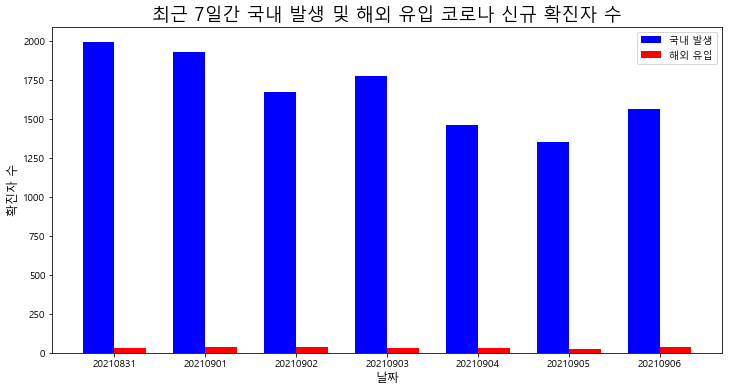

In [9]:
# 그래프 생성
import numpy as np
import matplotlib.pyplot as plt
def week_graph():
    bar_width = 0.35 # 막대 그래프 너비값
    index = np.arange(len(df_week_data['date'])) # x축 데이터 - 날짜
    plt.figure(figsize = (12,6))
    plt.bar(index, df_week_data['kg_corona'], bar_width, color = 'b', align = 'edge',label = '국내 발생')
    plt.bar(index + bar_width, df_week_data['extra_corona'], bar_width, color = 'r',align = 'edge',label = '해외 유입')
    plt.title('최근 7일간 국내 발생 및 해외 유입 코로나 신규 확진자 수', fontsize = 18)
    plt.ylabel('확진자 수', fontsize = 12)
    plt.xlabel('날짜', fontsize = 12)
    plt.xticks(index + bar_width, df_week_data['date'])#, fontsize=15
    plt.legend()
    plt.show()
week_graph()

#### 원 그래프(Pie Chart) : 국내 당일 지역별 코로나 누적 확진자 수

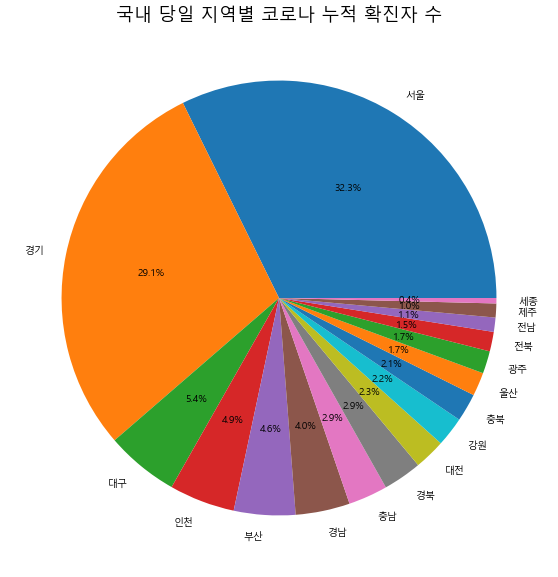

In [10]:
import matplotlib.pyplot as plt # 국내 발생 비율 - pie
def kr_graph():
    plt.figure(figsize = (30, 10))
    plt.title('국내 당일 지역별 코로나 누적 확진자 수', fontsize = 18)
    plt.pie(df_chorona_kr['area_corona_number'], labels = df_chorona_kr['area_name'], autopct = '%1.1f%%')
    plt.show()
kr_graph()

#### 지도(Map) : 국내 당일 지역별 코로나 누적 확진자 수

In [12]:
#API를 사용하여 각 지역의 위도와 경도를 추출
import requests

def find_places(searching):

    url = "https://dapi.kakao.com//v2/local/search/keyword.json?query={}".format(searching)

    headers = {
        "Authorization":"KakaoAK 카카오 REST API 키 값"
    }
    places = requests.get(url, headers = headers).json()["documents"]
    place = places[0]
    x = place["x"]
    y = place["y"]
    data = [x,y]
    
    return data

place_result = []
for area in area_data: #지역 이름만 추출
    find_place = find_places(area[0])
    place_result.append(find_place)

for i in range(len(area_data)):
    long = place_result[i][0]
    lat = place_result[i][1]
    area_data[i].append(long) #위도 넣기
    area_data[i].append(lat) #경도 넣기
    
area_result = pd.DataFrame(area_data)
area_result
area_result.columns = ["지역","확진자 수","거리두기 단계","위도","경도"]
area_result

,지역,확진자 수,거리두기 단계,위도,경도
0,서울,83138,4,126.93626843562683,37.62612118319853
1,경기,74847,4,126.9950525295552,37.685112988816826
2,대구,13962,3,128.56658131032162,35.85322716591636
3,인천,12559,4,126.76017260475932,37.457761295660084
4,부산,11761,3,129.159854668484,35.1585232170784
5,경남,10386,3,128.03923748038324,34.79980621956379
6,충남,7518,3,126.513481592784,36.3102317300706
7,경북,7397,3,129.282030311373,35.8367452157966
8,대전,5936,3,127.388037583592,36.3691431776998
9,강원,5656,3,128.910210247605,37.8034055083125


In [13]:
#지도 만들기
import folium
def kr_corona_map():
    sejong = [36.48, 127.29]
    map_korea = folium.Map(location = sejong, zoom_start = 7)

    for i in range(len(area_result)):
        area_name = area_result["지역"][i]
        area_corona_num = area_result["확진자 수"][i]
        long = float(area_result["위도"][i])
        lat = float(area_result["경도"][i])
        size = int(area_corona_num) / 1000
        folium.CircleMarker((lat, long), radius = size, color = "red", popup = area_name).add_to(map_korea)

    return map_korea
kr_corona_map()